In [15]:
import pandas as pd
import numpy as np
import warnings
import plotly.express as px
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import re
from collections import Counter

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv('sephora_website_dataset.csv')

# text = word_tokenize(df['details'].iloc[0])

# tags = nltk.pos_tag(text)
# desired_tags = {'NN', 'NNS','NNP','NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB','RBR','RBS'}
# filtered_words = set()
# for token, tag in tags:
#     if tag in desired_tags:
#         cleaned_word = token.lower().replace('-', '').replace('.', '').replace(',', '').replace('/', '')
#         filtered_words.add(cleaned_word)
        
# print(filtered_words)

def extract_nouns_verbs_adjectives(text):
    text = re.sub(r'(\w)\.(\w)', r'\1 \2', text)
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    desired_tags = {'NN', 'NNS','NNP','NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'JJ', 'JJR', 'JJS', 'RB','RBR','RBS'}
    filtered_words = set()
    
    for token, tag in tags:
        if tag in desired_tags:
            cleaned_word = token.lower().replace('-', '').replace('.', '').replace(',', '').replace("'", '')
            filtered_words.add(cleaned_word)
    
    return ', '.join(filtered_words)


# Apply the function to create a 'filtered_words' column for 4-5 star reviews
df['filtered_words_4_5'] = df[df['rating'].between(4, 5)]['details'].apply(extract_nouns_verbs_adjectives)
df['filtered_words_1_2'] = df[df['rating'].between(1, 3.5)]['details'].apply(extract_nouns_verbs_adjectives)
df['filtered_words_0_0'] = df[df['rating'].between(0, 0)]['details'].apply(extract_nouns_verbs_adjectives)

num_reviews_4_to_5 = len(df[df['rating'].between(4, 5)])
num_reviews_1_to_3 = len(df[df['rating'].between(1, 3.5)])
num_reviews_0_to_0 = len(df[df['rating'].between(0, 0)])

filtered_word_list_4_5 = [word.strip() for words in df['filtered_words_4_5'] if not pd.isna(words) for word in str(words).split(',')]
filtered_word_list_1_2 = [word.strip() for words in df['filtered_words_1_2'] if not pd.isna(words) for word in str(words).split(',')]
filtered_word_list_0_0 = [word.strip() for words in df['filtered_words_0_0'] if not pd.isna(words) for word in str(words).split(',')]

word_counts_4_5 = Counter(filtered_word_list_4_5)
word_counts_1_2 = Counter(filtered_word_list_1_2)
word_counts_0_0 = Counter(filtered_word_list_0_0)


most_common_words_1_2 = word_counts_1_2.most_common(20)
most_common_words_4_5 = word_counts_4_5.most_common(20)
most_common_words_0_0 = word_counts_0_0.most_common(20)


# Remove common words from the list of most common words in 1-2 star reviews
# most_common_words_1_2_filtered = [(word, count) for word, count in most_common_words_1_2 if word not in common_words]
# most_common_words_4_5_filtered = [(word, count) for word, count in most_common_words_4_5 if word not in common_words]


print("Most Common Words in 4-5 Star Reviews (After Removing Common Words):")
for word, count in most_common_words_4_5:
    print(f"{word}: {count/num_reviews_4_to_5}")
    
print()
print('1, 2, and 3 Star Words')
for word, count in most_common_words_1_2:
    print(f"{word}: {count/num_reviews_1_to_3}")
    
print()
print('0 Star Words')
for word, count in most_common_words_0_0:
    print(f"{word}: {count/num_reviews_0_to_0}")
    


print()   
common_words_1_5 = set(word_counts_4_5.keys()) & set(word_counts_1_2.keys())

print("Words with a difference in relative frequency > 0.05:")
for word in common_words_1_5:
    count_4_5 = word_counts_4_5[word]
    count_1_2 = word_counts_1_2[word]

    rel_freq_4_5 = count_4_5 / num_reviews_4_to_5
    rel_freq_1_2 = count_1_2 / num_reviews_1_to_3

    # Calculate the absolute difference in relative frequencies
    diff = abs(rel_freq_4_5 - rel_freq_1_2)

    if diff > 0.05:
        print(f"{word}: {rel_freq_4_5} (4-5 stars) vs. {rel_freq_1_2} (1-3.5 stars)")
        
        
        
print()   
common_words_0_5 = set(word_counts_4_5.keys()) & set(word_counts_0_0.keys())

print("Words with a difference in relative frequency > 0.05:")
for word in common_words_0_5:
    count_4_5 = word_counts_4_5[word]
    count_0_0 = word_counts_0_0[word]

    rel_freq_4_5 = count_4_5 / num_reviews_4_to_5
    rel_freq_0_0 = count_0_0 / num_reviews_0_to_0

    diff = abs(rel_freq_4_5 - rel_freq_0_0)

    if diff > 0.05 and count_0_0 > 10:
        print(f"{word}: {rel_freq_4_5} (4-5 stars) vs. {rel_freq_0_0} (No Reviews)")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arcve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\arcve\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Most Common Words in 4-5 Star Reviews (After Removing Common Words):
know: 0.7937120794263651
need: 0.7651682294539437
else: 0.7604798676227248
type: 0.5566740209597353
skin: 0.5410921125206839
parabens: 0.5085493656922229
product: 0.5027578599007171
formulated: 0.45311638168781027
sulfates: 0.4270546056260342
ingredients: 0.4220904578047435
’: 0.39409817981246553
phthalates: 0.3841698841698842
s: 0.34335355763927194
oil: 0.33645890788747934
ingredient: 0.33080529509100937
sls: 0.32349696635410924
crueltyfree: 0.32073910645339215
sles: 0.3204633204633205
callouts: 0.3185328185328185
dry: 0.30322669608383895

1, 2, and 3 Star Words
know: 0.8583662714097496
need: 0.8142292490118577
else: 0.8115942028985508
type: 0.5731225296442688
product: 0.5691699604743083
parabens: 0.5513833992094862
skin: 0.49604743083003955
formulated: 0.47101449275362317
ingredients: 0.44861660079051385
’: 0.4262187088274045
sulfates: 0.424901185770751
crueltyfree: 0.41436100131752307
phthalates: 0.3992094861660079

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arcve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\arcve\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Information for comparison between Fragrance and Cologne in category with significant difference of 0.2
Unique word in Fragrance is: oz/ with relative frequency: 0.45

Unique word in Cologne is: men with relative frequency: 0.2468
Unique word in Cologne is: man with relative frequency: 0.3418
Unique word in Cologne is: earthy with relative frequency: 0.3101
Unique word in Cologne is: woodyscent with relative frequency: 0.2025

Words with a difference in relative frequency > 0.2 in the column of category:
x: 0.4 Fragrance vs. 0.0063 Cologne
ml: 0.5 Fragrance vs. 0.0063 Cologne
description: 0.7 Fragrance vs. 0.2848 Cologne
set: 0.65 Fragrance vs. 0.0253 Cologne
freshness: 0.05 Fragrance vs. 0.2722 Cologne
beauty: 0.3 Fragrance vs. 0.057 Cologne
notes: 0.75 Fragrance vs. 0.9937 Cologne
rose: 0.55 Fragrance vs. 0.0696 Cologne
jasmine: 0.5 Fragrance vs. 0.0759 Cologne
family: 0.3 Fragrance vs. 0.5316 Cologne
collection: 0.25 Fragrance vs. 0.0253 Cologne
perfume: 0.25 Fragrance vs. 0.0127 Co

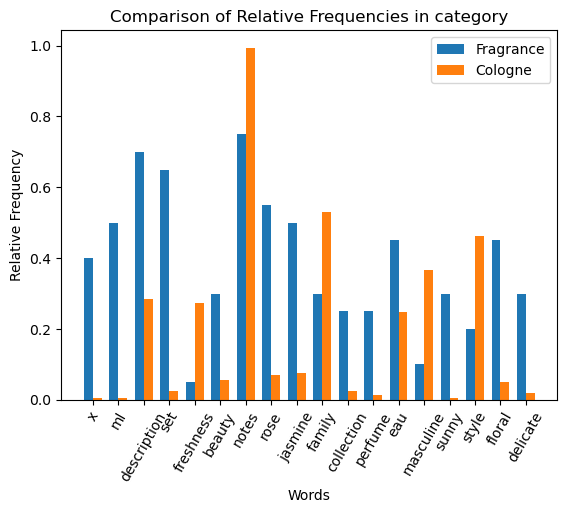



Information for comparison between Perfume and Cologne in category with significant difference of 0.2
Unique word in Perfume is: floralscent with relative frequency: 0.212
Unique word in Perfume is: floralskey with relative frequency: 0.2496


Words with a difference in relative frequency > 0.2 in the column of category:
men: 0.0436 Perfume vs. 0.2468 Cologne
woody: 0.1398 Perfume vs. 0.3734 Cologne
man: 0.0075 Perfume vs. 0.3418 Cologne
earthy: 0.1023 Perfume vs. 0.3101 Cologne
masculine: 0.0195 Perfume vs. 0.3671 Cologne
style: 0.2541 Perfume vs. 0.462 Cologne
floral: 0.3534 Perfume vs. 0.0506 Cologne
aromatic: 0.0301 Perfume vs. 0.2405 Cologne
type: 0.7353 Perfume vs. 0.5253 Cologne
family: 0.7383 Perfume vs. 0.5316 Cologne


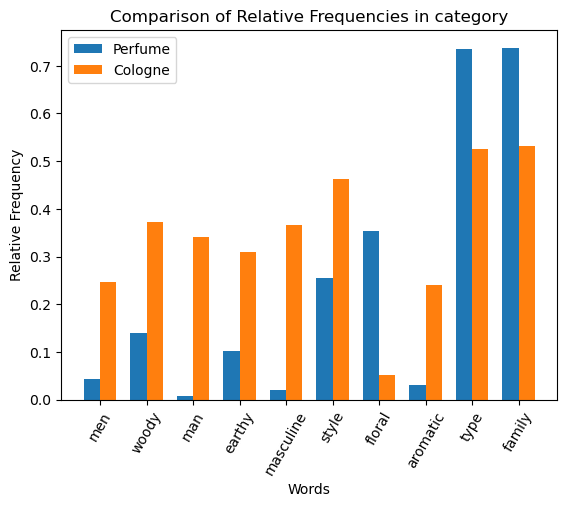



Information for comparison between Perfume and Fragrance in category with significant difference of 0.2
Unique word in Perfume is: floralscent with relative frequency: 0.212

Unique word in Fragrance is: x with relative frequency: 0.4

Words with a difference in relative frequency > 0.2 in the column of category:
ml: 0.003 Perfume vs. 0.5 Fragrance
description: 0.4211 Perfume vs. 0.7 Fragrance
set: 0.018 Perfume vs. 0.65 Fragrance
type: 0.7353 Perfume vs. 0.35 Fragrance
notes: 0.9714 Perfume vs. 0.75 Fragrance
rose: 0.2511 Perfume vs. 0.55 Fragrance
jasmine: 0.2692 Perfume vs. 0.5 Fragrance
family: 0.7383 Perfume vs. 0.3 Fragrance
eau: 0.2391 Perfume vs. 0.45 Fragrance
sunny: 0.0286 Perfume vs. 0.3 Fragrance
fresh: 0.3474 Perfume vs. 0.55 Fragrance
oz/: 0.0015 Perfume vs. 0.45 Fragrance


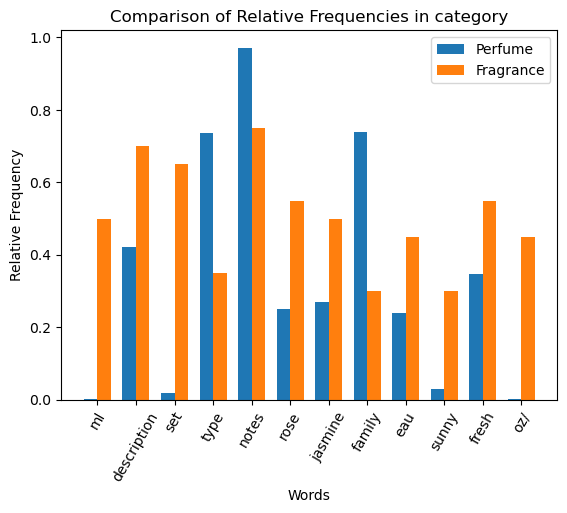



Information for comparison between (4, 5) and (1, 3.5) in rating with significant difference of 0.05


Words with a difference in relative frequency > 0.05 in the column of rating:
product: 0.5028 (4, 5) vs. 0.5692 (1, 3.5)
crueltyfree: 0.3207 (4, 5) vs. 0.4144 (1, 3.5)
know: 0.7937 (4, 5) vs. 0.8584 (1, 3.5)
notes: 0.1842 (4, 5) vs. 0.1324 (1, 3.5)
else: 0.7605 (4, 5) vs. 0.8116 (1, 3.5)
hair: 0.1776 (4, 5) vs. 0.253 (1, 3.5)
volume: 0.0404 (4, 5) vs. 0.0988 (1, 3.5)


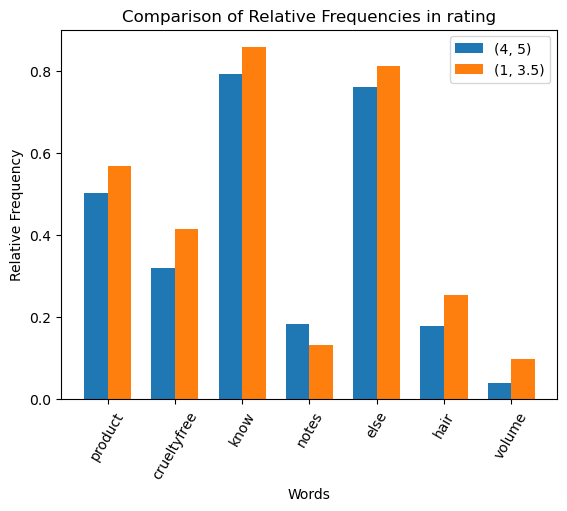



Information for comparison between (4, 5) and (0, 0) in rating with significant difference of 0.1


Words with a difference in relative frequency > 0.1 in the column of rating:
description: 0.0647 (4, 5) vs. 0.2412 (0, 0)
set: 0.1156 (4, 5) vs. 0.3291 (0, 0)
curly: 0.0622 (4, 5) vs. 0.1709 (0, 0)
callouts: 0.3185 (4, 5) vs. 0.4246 (0, 0)
product: 0.5028 (4, 5) vs. 0.3719 (0, 0)
ml: 0.0629 (4, 5) vs. 0.294 (0, 0)
fragrance: 0.2216 (4, 5) vs. 0.3342 (0, 0)
notes: 0.1842 (4, 5) vs. 0.299 (0, 0)
want: 0.1743 (4, 5) vs. 0.0402 (0, 0)
coilyhair: 0.0392 (4, 5) vs. 0.1457 (0, 0)
skin: 0.5411 (4, 5) vs. 0.3543 (0, 0)
wavy: 0.0721 (4, 5) vs. 0.1784 (0, 0)
✔: 0.1587 (4, 5) vs. 0.0327 (0, 0)
formulated: 0.4531 (4, 5) vs. 0.2286 (0, 0)
good: 0.1711 (4, 5) vs. 0.0477 (0, 0)
type: 0.5567 (4, 5) vs. 0.6784 (0, 0)
family: 0.1204 (4, 5) vs. 0.2538 (0, 0)
which: 0.1504 (4, 5) vs. 0.0251 (0, 0)
clean: 0.2165 (4, 5) vs. 0.1106 (0, 0)
oz/: 0.0865 (4, 5) vs. 0.3141 (0, 0)


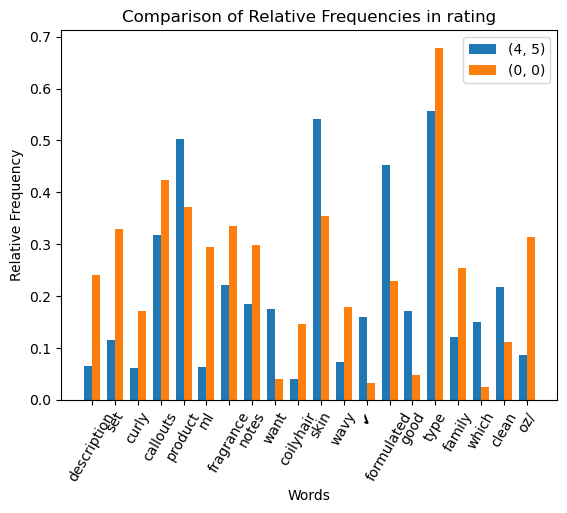



Information for comparison between (0, 0) and (1, 3.5) in rating with significant difference of 0.1


Words with a difference in relative frequency > 0.1 in the column of rating:
description: 0.2412 (0, 0) vs. 0.0567 (1, 3.5)
set: 0.3291 (0, 0) vs. 0.1291 (1, 3.5)
product: 0.3719 (0, 0) vs. 0.5692 (1, 3.5)
crueltyfree: 0.294 (0, 0) vs. 0.4144 (1, 3.5)
ml: 0.294 (0, 0) vs. 0.0652 (1, 3.5)
know: 0.706 (0, 0) vs. 0.8584 (1, 3.5)
’: 0.2965 (0, 0) vs. 0.4262 (1, 3.5)
fragrance: 0.3342 (0, 0) vs. 0.1772 (1, 3.5)
need: 0.691 (0, 0) vs. 0.8142 (1, 3.5)
notes: 0.299 (0, 0) vs. 0.1324 (1, 3.5)
s: 0.2538 (0, 0) vs. 0.3636 (1, 3.5)
want: 0.0402 (0, 0) vs. 0.224 (1, 3.5)
formula: 0.201 (0, 0) vs. 0.3254 (1, 3.5)
skin: 0.3543 (0, 0) vs. 0.496 (1, 3.5)
else: 0.691 (0, 0) vs. 0.8116 (1, 3.5)
✔: 0.0327 (0, 0) vs. 0.2016 (1, 3.5)
more…: 0.0101 (0, 0) vs. 0.114 (1, 3.5)
natural: 0.1709 (0, 0) vs. 0.274 (1, 3.5)
formulated: 0.2286 (0, 0) vs. 0.471 (1, 3.5)
parabens: 0.4397 (0, 0) vs. 0.5514 (1, 3.5)
goo

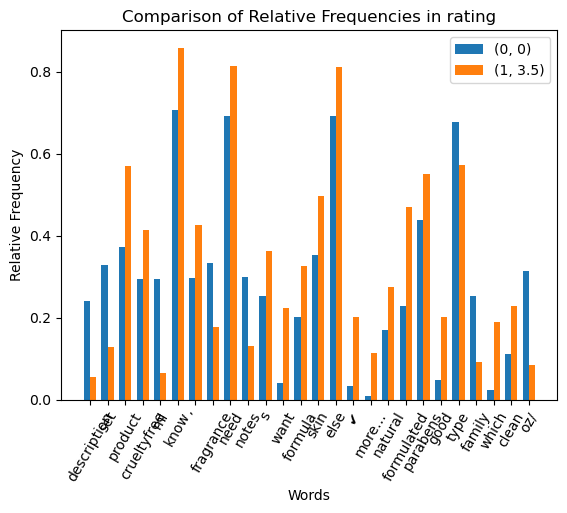



Information for comparison between (0, 35) and (100, 1000) in value_price with significant difference of 0.2


Words with a difference in relative frequency > 0.2 in the column of value_price:
product: 0.5846 (0, 35) vs. 0.2648 (100, 1000)
crueltyfree: 0.3925 (0, 35) vs. 0.1589 (100, 1000)
know: 0.8546 (0, 35) vs. 0.5957 (100, 1000)
notes: 0.1036 (0, 35) vs. 0.445 (100, 1000)
formula: 0.3314 (0, 35) vs. 0.1303 (100, 1000)
type: 0.4782 (0, 35) vs. 0.7413 (100, 1000)
else: 0.8218 (0, 35) vs. 0.5642 (100, 1000)
formulated: 0.4841 (0, 35) vs. 0.2363 (100, 1000)
fragrance: 0.1537 (0, 35) vs. 0.444 (100, 1000)
need: 0.8273 (0, 35) vs. 0.5642 (100, 1000)
parabens: 0.5549 (0, 35) vs. 0.2953 (100, 1000)
family: 0.0595 (0, 35) vs. 0.3544 (100, 1000)


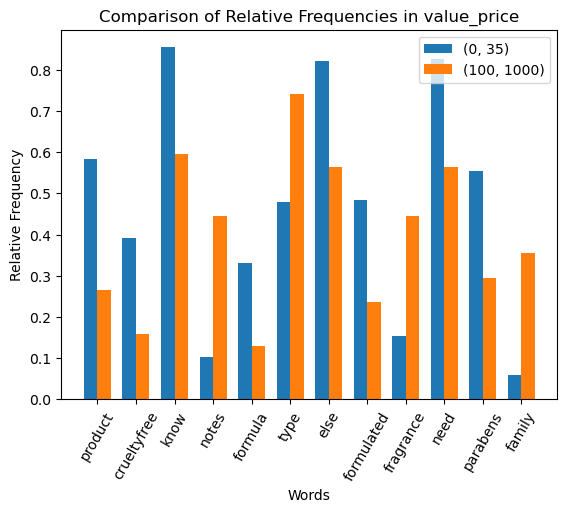

In [1]:
import pandas as pd
import numpy as np
import warnings
import plotly.express as px
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import re
from collections import Counter

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv('sephora_website_dataset.csv')

def extract_nouns_verbs_adjectives(text):
    text = re.sub(r'(\w)\.(\w)', r'\1 \2', text)
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    desired_tags = {'NN', 'NNS','NNP','NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'JJ', 'JJR', 'JJS', 'RB','RBR','RBS'}
    filtered_words = set()
    
    for token, tag in tags:
        if tag in desired_tags:
            cleaned_word = token.lower().replace('-', '').replace('.', '').replace(',', '').replace("'", '')
            filtered_words.add(cleaned_word)
    
    return ', '.join(filtered_words)

def list_of_words_return(text, SigWordNum):
    numDescripts = len(text)
    filtered_word_list = [word.strip() for words in text if not pd.isna(words) for word in str(words).split(',')]
    word_count = Counter(filtered_word_list)
    most_common_words = word_count.most_common(SigWordNum)
    return most_common_words, word_count, numDescripts

def print_list_words(text, word_count, numDescripts):
    for word, word_count in text:
        print(f"{word}: {word_count/numDescripts}")
    
    
def process_and_print_most_common_words(dataframe, column_name, rating_range, column_name_of_interest, num_words):
    filtered_df = dataframe[dataframe[column_name_of_interest].between(*rating_range)]
    extracted_words = filtered_df[column_name].apply(extract_nouns_verbs_adjectives)
    most_common_words, word_count, num_descriptions = list_of_words_return(extracted_words, num_words)
    print_list_words(most_common_words, word_count, num_descriptions)
    
def compare_and_print_common_words(dataframe, column_name1, range1, column_of_interest1, column_name2, range2, column_of_interest2,  sigDif):
    print(f"Information for comparison between {range1} and {range2} in {column_of_interest1} with significant difference of {sigDif}")
    if isinstance(range1, str):
        filtered_df1 = dataframe[dataframe[column_of_interest1] == range1]
    else:
        filtered_df1 = dataframe[dataframe[column_of_interest1].between(*range1)]
    
    extracted_words1 = filtered_df1[column_name1].apply(extract_nouns_verbs_adjectives)
    most_common_words1, word_count1, num_descriptions1 = list_of_words_return(extracted_words1, 10)

    if isinstance(range2, str):
        filtered_df2 = dataframe[dataframe[column_of_interest2] == range2]
    else:
        filtered_df2 = dataframe[dataframe[column_of_interest2].between(*range2)]
    
    extracted_words2 = filtered_df2[column_name2].apply(extract_nouns_verbs_adjectives)
    most_common_words2, word_count2, num_descriptions2 = list_of_words_return(extracted_words2, 10)
    
    common_words = set(word_count1.keys()) & set(word_count2.keys())
    
    unique_words1 = set(word_count1.keys()) - set(word_count2.keys())
    unique_words2 = set(word_count2.keys()) - set(word_count1.keys())
    
    for word in unique_words1:
        count1 = word_count1[word]
        rel_freq1 = count1 / num_descriptions1
        if rel_freq1 > sigDif:
            print(f"Unique word in {range1} is: {word} with relative frequency: {round(rel_freq1, 4)}")

    print()

    for word in unique_words2:
        count2 = word_count2[word]
        rel_freq2 = count2 / num_descriptions2
        if rel_freq2 > sigDif:
            print(f"Unique word in {range2} is: {word} with relative frequency: {round(rel_freq2, 4)}")
    
    print()
        
    print(f"Words with a difference in relative frequency > {sigDif} in the column of {column_of_interest1}:")
    
    displayArray = []
    
    for word in common_words:
        count1 = word_count1[word]
        count2 = word_count2[word]

        rel_freq1 = count1 / num_descriptions1
        rel_freq2 = count2 / num_descriptions2

        diff = abs(rel_freq1 - rel_freq2)

        if diff > sigDif:
            displayArray.append((word, round(rel_freq1, 4), round(rel_freq2, 4)))
            print(f"{word}: {round(rel_freq1, 4)} {range1} vs. {round(rel_freq2, 4)} {range2}")
            
    if displayArray:
        words, rel_freq1_values, rel_freq2_values = zip(*displayArray)
        x = range(len(words))
        width = 0.35

        fig, ax = plt.subplots()
        ax.bar(x, rel_freq1_values, width, label=f'{range1}')
        ax.bar([i + width for i in x], rel_freq2_values, width, label=f'{range2}')
        ax.set_xticks([i + width / 2 for i in x])
        ax.set_xticklabels(words, rotation=60)
        ax.set_xlabel('Words')
        ax.set_ylabel('Relative Frequency')
        ax.set_title(f"Comparison of Relative Frequencies in {column_of_interest1}")
        ax.legend()

        plt.show()
        print()

# rating_range = (4, 5)
# column_name = 'details'
# column_name_of_interest = 'rating'
# num_words = 20

compare_and_print_common_words(df, 'details', 'Fragrance', 'category', 'details', 'Cologne', 'category', 0.2)                           
print()

compare_and_print_common_words(df, 'details', 'Perfume', 'category', 'details', 'Cologne', 'category', 0.2)                           
print()

compare_and_print_common_words(df, 'details', 'Perfume', 'category', 'details', 'Fragrance', 'category', 0.2)                           
print()

compare_and_print_common_words(df, 'details', (4,5), 'rating', 'details', (1,3.5), 'rating', 0.05)
print()
compare_and_print_common_words(df, 'details', (4,5), 'rating', 'details', (0,0), 'rating', 0.1)
print()
compare_and_print_common_words(df, 'details', (0,0), 'rating', 'details', (1,3.5), 'rating', 0.1)
print()
compare_and_print_common_words(df, 'details', (0,35), 'value_price', 'details', (100,1000), 'value_price', 0.2)

# process_and_print_most_common_words(df, column_name, rating_range, column_name_of_interest, num_words)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arcve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\arcve\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Information for comparison between (0, 1000) and (100000, 1500000) in love with significant difference of 0.2


Words with a difference in relative frequency > 0.2 in the column of love:
product: 0.3708 (0, 1000) vs. 0.652 (100000, 1500000)
know: 0.6522 (0, 1000) vs. 0.9 (100000, 1500000)
fragrance: 0.3832 (0, 1000) vs. 0.1 (100000, 1500000)
need: 0.6255 (0, 1000) vs. 0.896 (100000, 1500000)
notes: 0.3689 (0, 1000) vs. 0.016 (100000, 1500000)
finish: 0.0776 (0, 1000) vs. 0.328 (100000, 1500000)
formula: 0.2068 (0, 1000) vs. 0.464 (100000, 1500000)
matte: 0.0186 (0, 1000) vs. 0.26 (100000, 1500000)
else: 0.6199 (0, 1000) vs. 0.892 (100000, 1500000)
type: 0.7193 (0, 1000) vs. 0.4 (100000, 1500000)
family: 0.2783 (0, 1000) vs. 0.024 (100000, 1500000)
shades: 0.0118 (0, 1000) vs. 0.364 (100000, 1500000)
color: 0.1 (0, 1000) vs. 0.304 (100000, 1500000)


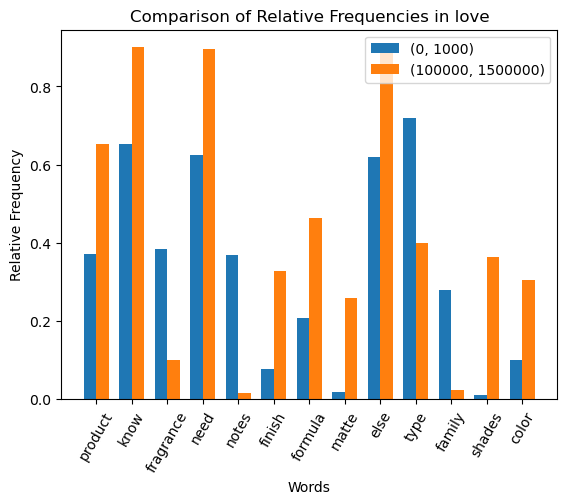

In [6]:
import pandas as pd
import numpy as np
import warnings
import plotly.express as px
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import re
from collections import Counter

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv('sephora_website_dataset.csv')

def extract_nouns_verbs_adjectives(text):
    text = re.sub(r'(\w)\.(\w)', r'\1 \2', text)
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    desired_tags = {'NN', 'NNS','NNP','NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'JJ', 'JJR', 'JJS', 'RB','RBR','RBS'}
    filtered_words = set()
    
    for token, tag in tags:
        if tag in desired_tags:
            cleaned_word = token.lower().replace('-', '').replace('.', '').replace(',', '').replace("'", '')
            filtered_words.add(cleaned_word)
    
    return ', '.join(filtered_words)

def list_of_words_return(text, SigWordNum):
    numDescripts = len(text)
    filtered_word_list = [word.strip() for words in text if not pd.isna(words) for word in str(words).split(',')]
    word_count = Counter(filtered_word_list)
    most_common_words = word_count.most_common(SigWordNum)
    return most_common_words, word_count, numDescripts

def print_list_words(text, word_count, numDescripts):
    for word, word_count in text:
        print(f"{word}: {word_count/numDescripts}")
    
    
def process_and_print_most_common_words(dataframe, column_name, rating_range, column_name_of_interest, num_words):
    filtered_df = dataframe[dataframe[column_name_of_interest].between(*rating_range)]
    extracted_words = filtered_df[column_name].apply(extract_nouns_verbs_adjectives)
    most_common_words, word_count, num_descriptions = list_of_words_return(extracted_words, num_words)
    print_list_words(most_common_words, word_count, num_descriptions)
    
def compare_and_print_common_words(dataframe, column_name1, range1, column_of_interest1, column_name2, range2, column_of_interest2,  sigDif):
    print(f"Information for comparison between {range1} and {range2} in {column_of_interest1} with significant difference of {sigDif}")
    if isinstance(range1, str):
        filtered_df1 = dataframe[dataframe[column_of_interest1] == range1]
    else:
        filtered_df1 = dataframe[dataframe[column_of_interest1].between(*range1)]
    
    extracted_words1 = filtered_df1[column_name1].apply(extract_nouns_verbs_adjectives)
    most_common_words1, word_count1, num_descriptions1 = list_of_words_return(extracted_words1, 10)

    if isinstance(range2, str):
        filtered_df2 = dataframe[dataframe[column_of_interest2] == range2]
    else:
        filtered_df2 = dataframe[dataframe[column_of_interest2].between(*range2)]
    
    extracted_words2 = filtered_df2[column_name2].apply(extract_nouns_verbs_adjectives)
    most_common_words2, word_count2, num_descriptions2 = list_of_words_return(extracted_words2, 10)
    
    common_words = set(word_count1.keys()) & set(word_count2.keys())
    
    unique_words1 = set(word_count1.keys()) - set(word_count2.keys())
    unique_words2 = set(word_count2.keys()) - set(word_count1.keys())
    
    for word in unique_words1:
        count1 = word_count1[word]
        rel_freq1 = count1 / num_descriptions1
        if rel_freq1 > sigDif:
            print(f"Unique word in {range1} is: {word} with relative frequency: {round(rel_freq1, 4)}")

    print()

    for word in unique_words2:
        count2 = word_count2[word]
        rel_freq2 = count2 / num_descriptions2
        if rel_freq2 > sigDif:
            print(f"Unique word in {range2} is: {word} with relative frequency: {round(rel_freq2, 4)}")
    
    print()
        
    print(f"Words with a difference in relative frequency > {sigDif} in the column of {column_of_interest1}:")
    
    displayArray = []
    
    for word in common_words:
        count1 = word_count1[word]
        count2 = word_count2[word]

        rel_freq1 = count1 / num_descriptions1
        rel_freq2 = count2 / num_descriptions2

        diff = abs(rel_freq1 - rel_freq2)

        if diff > sigDif:
            displayArray.append((word, round(rel_freq1, 4), round(rel_freq2, 4)))
            print(f"{word}: {round(rel_freq1, 4)} {range1} vs. {round(rel_freq2, 4)} {range2}")
            
    if displayArray:
        words, rel_freq1_values, rel_freq2_values = zip(*displayArray)
        x = range(len(words))
        width = 0.35

        fig, ax = plt.subplots()
        ax.bar(x, rel_freq1_values, width, label=f'{range1}')
        ax.bar([i + width for i in x], rel_freq2_values, width, label=f'{range2}')
        ax.set_xticks([i + width / 2 for i in x])
        ax.set_xticklabels(words, rotation=60)
        ax.set_xlabel('Words')
        ax.set_ylabel('Relative Frequency')
        ax.set_title(f"Comparison of Relative Frequencies in {column_of_interest1}")
        ax.legend()

        plt.show()
        print()

# rating_range = (4, 5)
# column_name = 'details'
# column_name_of_interest = 'rating'
# num_words = 20

# compare_and_print_common_words(df, 'details', 'Fragrance', 'category', 'details', 'Cologne', 'category', 0.2)                           
# print()

# compare_and_print_common_words(df, 'details', 'Perfume', 'category', 'details', 'Cologne', 'category', 0.2)                           
# print()

# compare_and_print_common_words(df, 'details', 'Perfume', 'category', 'details', 'Fragrance', 'category', 0.2)                           
# print()

compare_and_print_common_words(df, 'details', (0,1000), 'love', 'details', (100000,1500000), 'love', 0.2)
print()
# compare_and_print_common_words(df, 'details', (4,5), 'rating', 'details', (0,0), 'rating', 0.1)
# print()
# compare_and_print_common_words(df, 'details', (0,0), 'rating', 'details', (1,3.5), 'rating', 0.1)
# print()
# compare_and_print_common_words(df, 'details', (0,35), 'value_price', 'details', (100,1000), 'value_price', 0.2)

# process_and_print_most_common_words(df, column_name, rating_range, column_name_of_interest, num_words)

